<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/Figure1a_1b_bond_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q git+https://mshuaibi@bitbucket.org/andrewpeterson/amp.git
!pip install -q --upgrade dftbook

import dftbook
dftbook.setup_colab()

     |████████████████████████████████| 296kB 3.4MB/s 
     |████████████████████████████████| 6.7MB 7.6MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 2.1MB 53.7MB/s 
     |████████████████████████████████| 12.8MB 241kB/s 
     |████████████████████████████████| 110.5MB 120kB/s 
     |████████████████████████████████| 3.8MB 47.4MB/s 
     |████████████████████████████████| 512kB 38.7MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... do

In [ ]:
import ase
import time
import sys
import copy

from amp.descriptor.gaussian import Gaussian
from amptorch.gaussian import SNN_Gaussian
from amptorch.model import BPNN, CustomMSELoss
from amptorch.data_preprocess import AtomsDataset, collate_amp
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.delta_models.morse import morse_potential

import torch

import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
import seaborn as sns
from ase.calculators.singlepoint import SinglePointCalculator as sp

import skorch.callbacks.base
from skorch.utils import to_numpy
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 10.0 #EMT asap_cutoff: False

In [ ]:
from espresso import Espresso
import ase.io
# Define Training data
energies = []
forces = []
distances = np.linspace(1, 5, 30)
images = []

calc = Espresso(pw=500.0,
                calculation='scf',
                xc='PBE')

label = "bond_example"
for displacement in distances:
    atoms = Atoms("CuCu", [(0, 0, 0), (0, 0, displacement)])
    atoms.set_cell([10, 10, 10])
    atoms.center()
    atoms.set_calculator(copy.deepcopy(calc))
    energy = atoms.get_potential_energy(apply_constraint=False)
    forces = atoms.get_forces(apply_constraint=False)
    atoms.set_calculator(sp(atoms, energy=energy, forces=forces))
    energies.append(energy)
    forces.append(forces)
    images.append(atoms)

ase.io.write("cu_bond.traj", images)
energies = np.array(energies)
forces = np.concatenate(np.array(forces))
distances = np.array(distances)

In [ ]:
# Limited dataset
images = ase.io.read("cu_bond.traj", ":")
distances = np.linspace(1,5,30)
energies = np.array([image.get_potential_energy() for image in images])
energies -= energies[-1]
training_small = np.array([7, 8, 9])
training_images_small = [images[i] for i in training_small]
training_energies_small = energies[training_small]
training_distances_small = distances[training_small]

# Diverse dataset
training_large = np.array([1, 5, 7, 9, 11, 14, 24, 25, 28])
training_images_large = [images[i] for i in training_large]
training_energies_large = energies[training_large]
training_distances_large = distances[training_large]

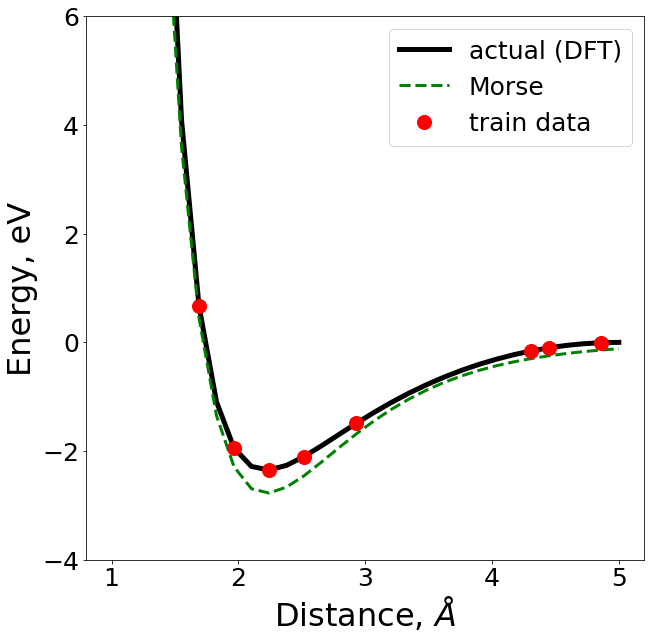

In [ ]:
morse_model = morse_potential(images, Gs["cutoff"], "test", combo="mean")
morse_energies, morse_forces, num_atoms = morse_model.morse_pred(images)
morse_data = [morse_energies, morse_forces, num_atoms, morse_model]


fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=5, label="actual (DFT)")
ax1.plot(distances, morse_energies, color="g", linewidth=3, linestyle="--", label="Morse")
ax1.plot(training_distances_large, training_energies_large, "ro", label="train data", markersize=14)
ax1.set_ylim(top=6)
ax1.set_ylim(bottom=-4)
ax1.tick_params(axis="both", labelsize=25)
plt.legend(fontsize=25)
plt.savefig("morse_cu.png", dpi=300)

In [ ]:
def train(training_images, test_images, label, morse=False):
    morse_data = None
    if morse:
        morse_model = morse_potential(training_images, Gs["cutoff"], label, combo="mean")
        morse_energies, morse_forces, num_atoms = morse_model.morse_pred(training_images)
        morse_data = [morse_energies, morse_forces, num_atoms, morse_model]

    forcetraining = True
    training_data = AtomsDataset(
        training_images,
        SNN_Gaussian,
        Gs,
        forcetraining=forcetraining,
        label=label,
        cores=1,
        delta_data=morse_data,
    )
    unique_atoms = training_data.elements
    fp_length = training_data.fp_length
    device = "cpu"

    net = NeuralNetRegressor(
        module=BPNN(
            unique_atoms, [fp_length, 3, 5], device, forcetraining=forcetraining
        ),
        criterion=CustomMSELoss,
        criterion__force_coefficient=0.04,
        optimizer=torch.optim.LBFGS,
        optimizer__line_search_fn="strong_wolfe",
        lr=1e-2,
        batch_size=len(training_data),
        max_epochs=100,
        iterator_train__collate_fn=collate_amp,
        iterator_train__shuffle=False,
        iterator_valid__collate_fn=collate_amp,
        device=device,
        train_split=0,
        callbacks=[
            EpochScoring(
                forces_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
            EpochScoring(
                energy_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
        ],
    )
    calc = AMP(training_data, net, label)
    calc.train(overwrite=True)

    ml_delta_e_pred = [calc.get_potential_energy(image) for image in test_images]
    ml_delta_f_pred = [calc.get_forces(image) for image in test_images]
    
    return ml_delta_e_pred, ml_delta_f_pred

In [ ]:
# ML large data spread
ml_pred_large, ml_forces_large = train(training_images_large, copy.deepcopy(images), label="bond_large", morse=False)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          7.1608         42.0535        9.2189  0.0548
      2          4.1746         21.3737        2.6974  0.0565
      3          1.2080          2.2760        0.1259  0.0570
      4          0.1351          0.8863        0.0038  0.0628
      5          0.0840          0.3314        0.0009  0.0610
      6          0.0458          0.3089        0.0004  0.0651
      7          0.0271          0.2752        0.0003  0.0681
      8          0.0263          0.2421        0.0002  0.0627
      9          0.0296          0.1738        0.0002  0.0729
     10          0.0127          0.0700        0.0000  0.0691
     11          0.0090          0.0507        0.0000  0.0727
     12          0.0086          0.0367        0.0000  0.0691
     13          0.0071          0.0353        0.0000  0.0812
     14          

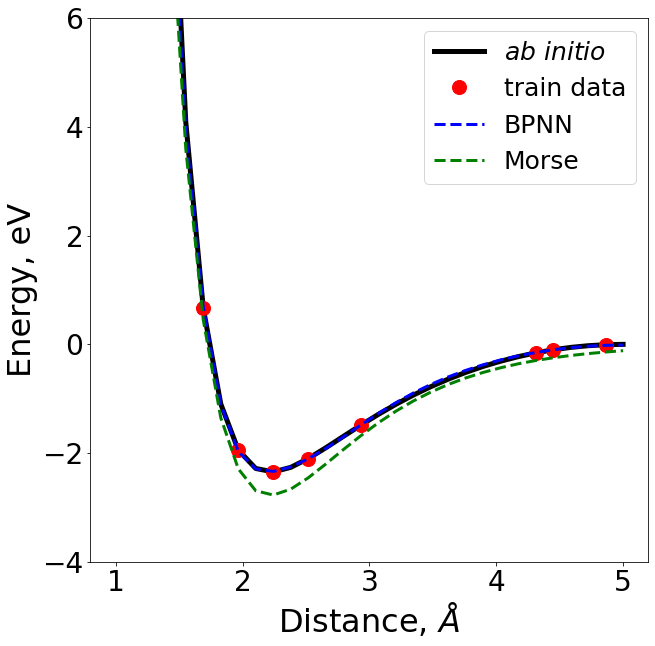

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=5, label="$ab\ initio$")
ax1.plot(training_distances_large, training_energies_large, "ro", label="train data", markersize=14)
ax1.plot(distances, ml_pred_large, color="blue", ls='--', linewidth=3, label="BPNN")
ax1.plot(distances, morse_energies, color="g", linewidth=3, linestyle="--", label="Morse")
ax1.tick_params(axis="both", labelsize=28)
ax1.set_ylim(top=6)
ax1.set_ylim(bottom=-4)
plt.legend(fontsize=25)
plt.savefig('large_data.png', dpi=300)

In [ ]:
# ML limited data spread
ml_pred_small, ml_forces_small = train(training_images_small, images, label="bond_small", morse=False)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.0841          1.3264        9.8362  0.0729
      2          0.0160          0.1367        0.1274  0.0507
      3          0.0079          0.1085        0.0678  0.0561
      4          0.0068          0.0241        0.0088  0.0546
      5          0.0069          0.0135        0.0070  0.0605
      6          0.0033          0.0123        0.0021  0.0637
      7          0.0002          0.0009        0.0000  0.0561
      8          0.0000          0.0000        0.0000  0.0126
      9          0.0000          0.0000        0.0000  0.0162
     10          0.0000          0.0000        0.0000  0.0116
     11          0.0000          0.0000        0.0000  0.0110
     12          0.0000          0.0000        0.0000  0.0126
     13          0.0000          0.0000        0.0000  0.0101
     14          

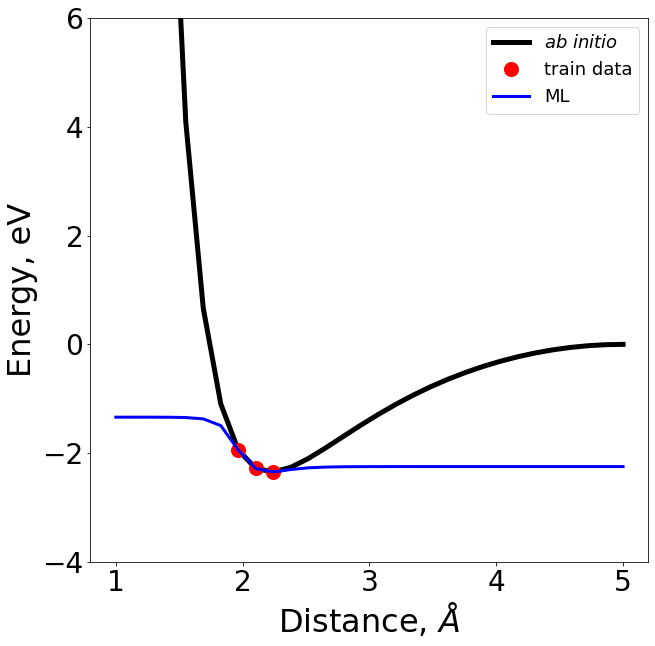

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=5, label="$ab\ initio$")
ax1.plot(training_distances_small, training_energies_small, "ro", label="train data", markersize=14)
ax1.plot(distances, ml_pred_small, color="blue", ls='-', linewidth=3, label="ML")
# ax1.plot(distances, ml_forces_small)
ax1.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=18)
ax1.set_ylim(bottom=-4)
ax1.set_ylim(top=6)
plt.savefig('small_data.png', dpi=300)

In [ ]:
# ML limited data spread with Morse
ml_pred_small_morse, ml_forces_small_morse = train(training_images_small, images, label="bond_small_morse", morse=True)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.0162          0.2054        6.7828  0.0609
      2          0.0097          0.0319        0.4680  0.0588
      3          0.0019          0.0035        0.0142  0.0508
      4          0.0007          0.0013        0.0020  0.0595
      5          0.0004          0.0010        0.0008  0.0572
      6          0.0002          0.0008        0.0003  0.0590
      7          0.0002          0.0005        0.0002  0.0583
      8          0.0001          0.0004        0.0001  0.0670
      9          0.0000          0.0001        0.0000  0.0664
     10          0.0000          0.0000        0.0000  0.0467
     11          0.0000          0.0000        0.0000  0.0128
     12          0.0000          0.0000        0.0000  0.0161
     13          0.0000          0.0000        0.0000  0.0065
     14          

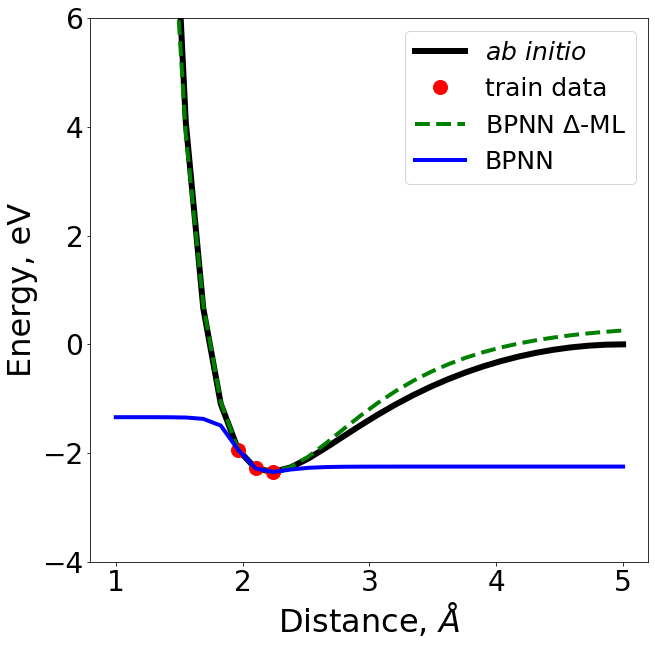

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=6, label="$ab\ initio$")
ax1.plot(training_distances_small, training_energies_small, "ro", label="train data", markersize=14)
ax1.plot(distances, ml_pred_small_morse, color="g", ls='--', linewidth=4, label="BPNN $\Delta$-ML")
ax1.plot(distances, ml_pred_small, color="blue", ls='-', linewidth=4, label="BPNN")
ax1.tick_params(axis="both", labelsize=28)
ax1.set_ylim(top=6)
ax1.set_ylim(bottom=-4)
plt.legend(fontsize=25)
plt.savefig('small_data_morse.png', dpi=300)